In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage as ski
from skimage import filters
from skimage import io
from skimage.morphology import disk, square
from skimage.filters.rank import mean, otsu
from scipy.ndimage.interpolation import rotate
from scipy import ndimage
from scipy import stats
from tqdm import tqdm  

import warnings
warnings.filterwarnings('ignore')

import utils as ut

plt.set_cmap(cmap=mpl.cm.gray);
mpl.rcParams.update({'font.size': 12});
#plt.rcParams['figure.dpi'] = 150

<Figure size 432x288 with 0 Axes>

In [2]:
# Filling with STD
# https://matplotlib.org/3.3.4/gallery/recipes/fill_between_alpha.html

# Pmat Dataset

In [3]:
#indexes_supine = [1, 8, 9, 10, 11, 12, 15, 16, 17]
indexes_all = np.arange(1,17)

subject = 1
index = 1
fn = 'data/PmatData/experiment-i/S{}/{}.txt'.format(subject,index)
img_csv = np.genfromtxt(fn)

# discart first 10 and last 10
img_csv = img_csv[10:-10,:]
n_frames,_ = img_csv.shape

# to get size of the read file
print(img_csv.shape)

(62, 2048)


#### Loop over all the frames

In [4]:
pts_dict = {}

pts_dict['vert'] = ut.frames_medaxis(img_csv, dataset='PMat', axis=0)
pts_dict['horiz'] = ut.frames_medaxis(img_csv, dataset='PMat', axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 673.93it/s]


### Frame #30

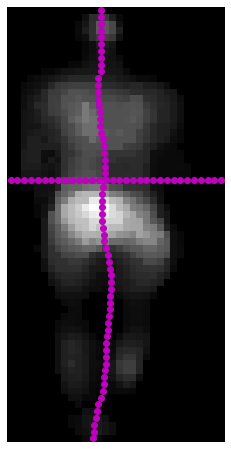

In [5]:
frame_number = 30

img_frame, img_bin = ut.get_frame(img_csv, frame_number, dataset='PMat', mask=True)

pts_vert = pts_dict['vert'][frame_number]
pts_horiz = pts_dict['horiz'][frame_number]

ut.plot_img_marks(img_frame, dots_v=pts_vert, dots_h=pts_horiz)
plt.savefig(f'figs/pmat_f{frame_number}_division')

In [6]:
means_dict = ut.quadrant_analysis(img_csv, pts_dict, dataset='PMat', func=np.mean)
#prs_mean = np.mean([left_means, right_means], axis=0)

Quadrant analysis...


100%|█████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 911.78it/s]


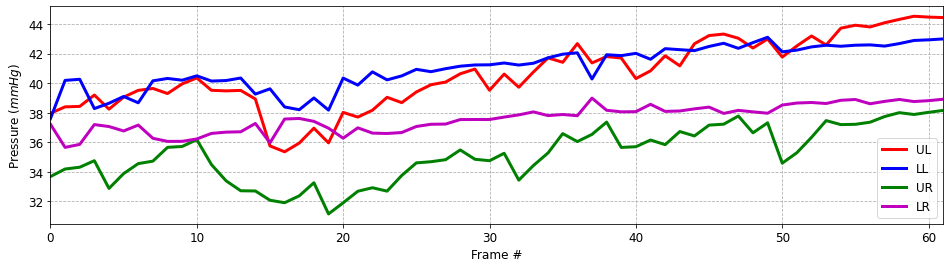

In [7]:
ut.plot_pressures(means_dict)#, title='PMat - Mean Pressure')
plt.savefig('figs/pmat_prs_frame.png', bbox_inches='tight')

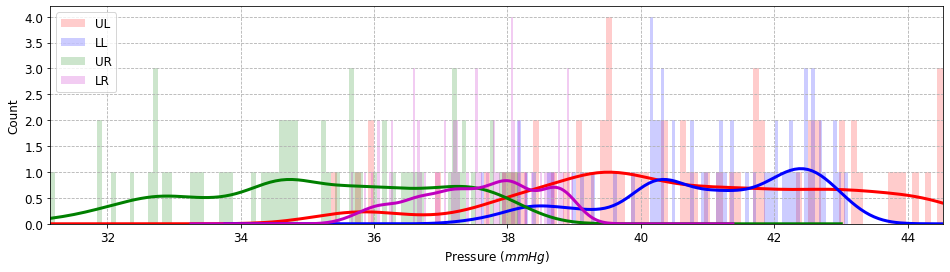

In [8]:
ut.plot_distributions(means_dict, kde=True)
plt.savefig('figs/pmat_prs_hist.png', bbox_inches='tight')

In [9]:
#ut.plot_kdes(means_dict, title='PMat - Mean Pressure')
#plt.savefig('figs/pmat_prs_kde.png', bbox_inches='tight')

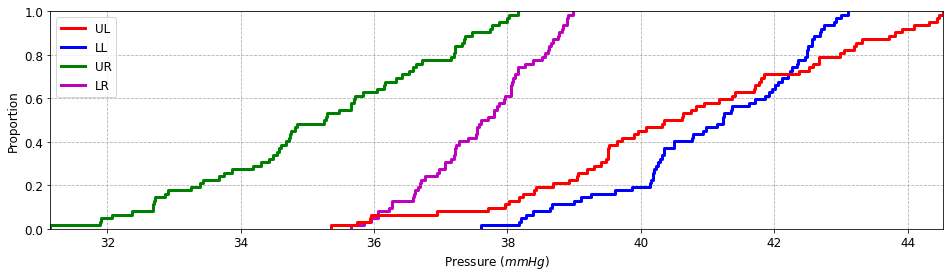

In [10]:
ut.plot_ecdf(means_dict)
plt.savefig('figs/pmat_prs_ecdf.png', bbox_inches='tight')

# SLOPE NOT WORKING!!!

In [81]:
# slope of the curve 
def slope (v):
    #print('>> ', len(v), np.mean(v))
    #print(v)
    y = np.sort(v)
    x = np.arange(1, len(y)+1) / len(y)
    
    print('len x/y:', len(x), len(y))
    
    # 25% and 75%
    #x_ind25 = np.where(x == x[len(x)//4])[0]
    #x_ind75 = np.where(x == x[len(x)//4*3])[0]
    
    x_ind25 = int(len(x) // 4)
    x_ind75 = int(len(x) // 4 * 3)
    
    print('x 25/75:', x_ind25, x_ind75)

    y_ind25 = y[x_ind25]
    y_ind75 = y[x_ind75]
    
    print('y 25/75:', y_ind25, y_ind75)

    p1, p2 = {}, {}
    p1['x'], p1['y'] = x_ind25, y_ind25
    p2['x'], p2['y'] = x_ind75, y_ind75
    
    print('p1:', p1, '\np2:', p2)

    
    m = (p2['y'] - p1['y']) / (p2['x'] - p1['x'])
    return m

In [82]:
62 // 4 

15

In [83]:
means_dict.keys()

dict_keys(['UL', 'LL', 'UR', 'LR'])

In [84]:
print(len(means_dict['LR']))
print('>> slope:', slope(means_dict['LR']))

print(len(means_dict['UL']))
print('>> slope:', slope(means_dict['UL']))

62
len x/y: 62 62
x 25/75: 15 45
y 25/75: 9.19321995249751 9.501040693125677
p1: {'x': 15, 'y': 9.19321995249751} 
p2: {'x': 45, 'y': 9.501040693125677}
>> slope: 0.01026069135427227
62
len x/y: 62 62
x 25/75: 15 45
y 25/75: 4.033820317408105 4.415308811220234
p1: {'x': 15, 'y': 4.033820317408105} 
p2: {'x': 45, 'y': 4.415308811220234}
>> slope: 0.012716283127070967


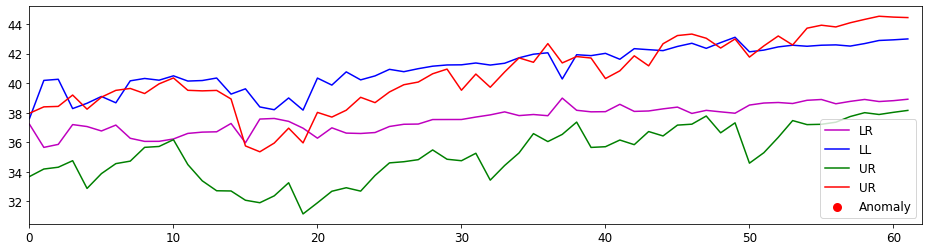

In [14]:
ut.anomaly_detection(means_dict,contamination=1e-20)

## XSensor Data - Limbs Movement

In [15]:
fn_abnormal = 'data/LeosData/Abnormal_PSMLAB-20210106.xlsx'
fn_normal = 'data/LeosData/Normal_PSMLAB-20210106.xlsx'

### Abnormal movement

In [16]:
# only if needed to read from excel
#pres_dat = ut.read_excel_data(fn_abnormal)
#ut.data_to_pkl(pres_dat, 'data/LeosData/Abnormal_PSMLAB-20210106.pkl')

# read previoiusly conoverted pickle
press_data = ut.load_pkl('data/LeosData/Abnormal_PSMLAB-20210106.pkl')

# discarting: first/last 10
press_data = press_data[10:-10,:,:]

--> Data loaded!


In [17]:
# Leo's data has a different range. 
# Probably is because of some normalization done via code, but I couldnt figure it out where it came from
# Here I try to turn it back just by dividing by the max
press_data_shape = press_data.shape

press_tmp = press_data.reshape((1,-1)) / press_data.max()
press_data = press_tmp.reshape(press_data_shape)

print(press_data.shape)
print(press_data.min(), press_data.max())

(173, 118, 48)
0.0006775067750677507 1.0


### Frame #20, t = 2

In [18]:
pts_dict = {}

pts_dict['vert'] = ut.frames_medaxis(press_data, dataset='XSensor', axis=0)
pts_dict['horiz'] = ut.frames_medaxis(press_data, dataset='XSensor', axis=1)

100%|███████████████████████████████████████████████████████████████████████████████| 173/173 [00:01<00:00, 172.14it/s]


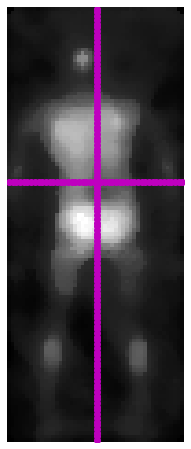

In [19]:
frame_number = 20

img_frame, img_bin = ut.get_frame(press_data, frame_number, dataset='XSensor', mask=True)

pts_vert = pts_dict['vert'][frame_number]
pts_horiz = pts_dict['horiz'][frame_number]

ut.plot_img_marks(img_frame, dots_v=pts_vert, dots_h=pts_horiz)

In [20]:
# with XSensor left-right are inverted.
# we see the patient from the front side
#right_means, left_means = ut.left_right_analysis(press_data, frames_pts, dataset='XSensor')

means_dict = ut.quadrant_analysis(press_data, pts_dict, dataset='XSensor', func=np.mean)

#right_means = ut.rolling_window(right_means, 2)
#left_means = ut.rolling_window(left_means, 2)

#prs_mean = np.mean([left_means, right_means], axis=0)

Quadrant analysis...


100%|███████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 550.96it/s]


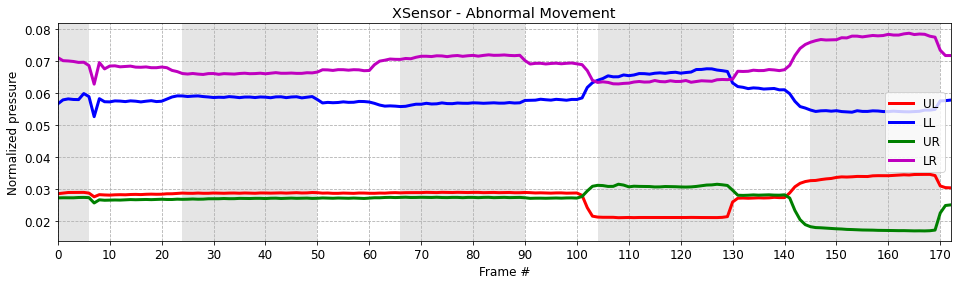

In [21]:
#press_dict = {
#    'L': left_means,
#    'R': right_means,
#    '$\mu$': prs_mean}

shaded_areas = {
    'arms off the bed': [0, 6],
    'left arm raised': [24, 50],
    'right arm raised': [66, 90],
    'left leg raised': [104, 130],
    'right leg raised': [145, 170]}

ut.plot_pressures(means_dict, shaded_areas, 
                  title='XSensor - Abnormal Movement', 
                  ylabel='Normalized pressure');
plt.savefig('figs/xsensor_leo_abnormal_prs_frame.png', bbox_inches='tight')

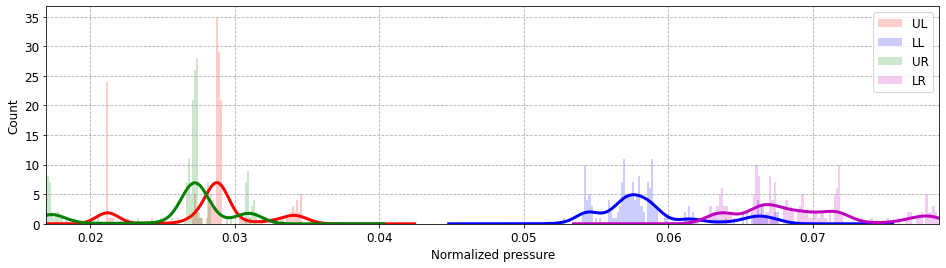

In [22]:
ut.plot_distributions(means_dict, 
                      title='ABNORMAL Movement: Mean pressure across-frames', 
                      xlabel='Normalized pressure',
                      kde=True)
plt.savefig('figs/xsensor_leo_abnormal_prs_hist.png', bbox_inches='tight')

In [23]:
#ut.plot_kdes(means_dict)
#plt.savefig('xsensor_leo_abnormal_prs_kde.png', bbox_inches='tight')

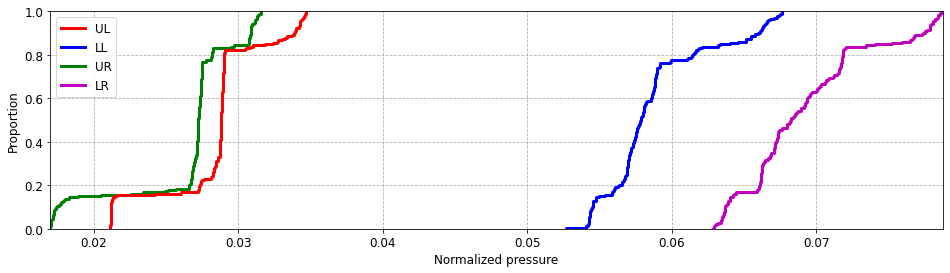

In [24]:
#del press_dict['$\mu$']
ut.plot_ecdf(means_dict, xlabel='Normalized pressure')
plt.savefig('figs/xsensor_leo_abnormal_prs_ecdf.png', bbox_inches='tight')

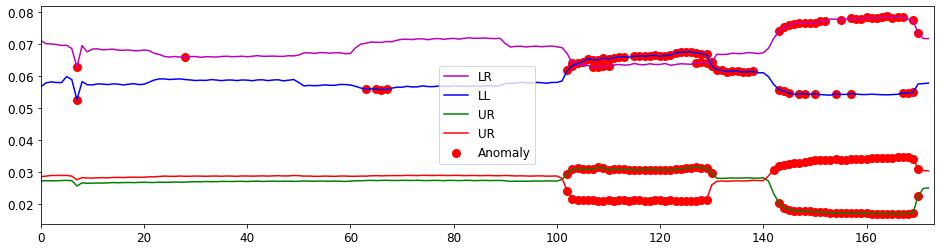

In [29]:
ut.anomaly_detection(means_dict, contamination=0.2)

### Normal movement

In [36]:
#pres_dat = ut.read_excel_data(fn_normal)
#ut.data_to_pkl(pres_dat, 'LeosData/Normal_PSMLAB-20210106.pkl')

# read previoiusly converted pickle
press_data = ut.load_pkl('data/LeosData/Normal_PSMLAB-20210106.pkl')

# discarting: first/last 10
press_data = press_data[10:-10,:,:]

--> Data loaded!


In [37]:
# Leo's data has a different range. 
# Probably is because of some normalization done via code, but I couldnt figure it out where it came from
# Here I try to turn it back just by dividing by the max
press_data_shape = press_data.shape

press_tmp = press_data.reshape((1,-1)) / press_data.max()
press_data = press_tmp.reshape(press_data_shape)

print(press_data.shape)
print(press_data.min(), press_data.max())

(96, 118, 48)
0.00021267545725223307 1.0


In [38]:
pts_dict = {}

pts_dict['vert'] = ut.frames_medaxis(press_data, dataset='XSensor', axis=0)
pts_dict['horiz'] = ut.frames_medaxis(press_data, dataset='XSensor', axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 186.41it/s]


### Frame #50, t = 2

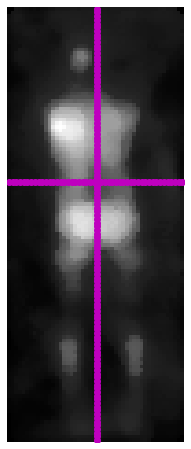

In [39]:
frame_number = 50

img_frame, img_bin = ut.get_frame(press_data, frame_number, dataset='XSensor', mask=True)

pts_vert = pts_dict['vert'][frame_number]
pts_horiz = pts_dict['horiz'][frame_number]

ut.plot_img_marks(img_frame, dots_v=pts_vert, dots_h=pts_horiz)

In [40]:
means_dict = ut.quadrant_analysis(press_data, pts_dict, dataset='XSensor', func=np.mean)

#right_means = ut.rolling_window(right_means, 2)
#left_means = ut.rolling_window(left_means, 2)

#prs_mean = np.mean([left_means, right_means], axis=0)

Quadrant analysis...


100%|█████████████████████████████████████████████████████████████████████████████████| 96/96 [00:00<00:00, 631.59it/s]


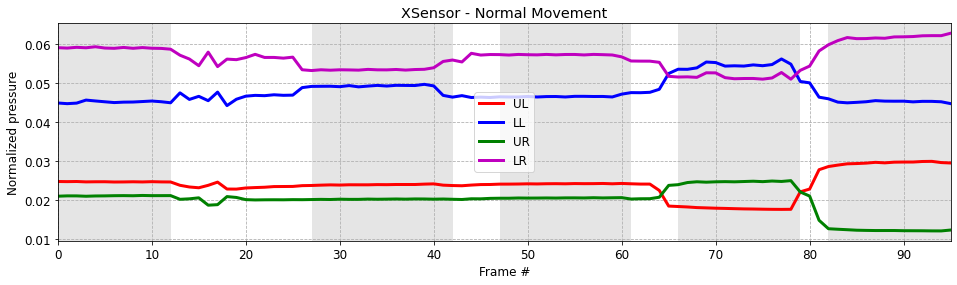

In [41]:
#press_dict = {
#    'L': left_means,
#    'R': right_means,
#    '$\mu$': prs_mean}

shaded_areas = {
    'both arms off the mattress': [0, 12],
    'left arm raised': [27, 42],
    'right arm raised': [47, 61],
    'left leg raised': [66, 79],
    'right leg raised': [82, 96]}

ut.plot_pressures(means_dict, shaded_areas, 
                  title='XSensor - Normal Movement', 
                  ylabel='Normalized pressure');
plt.savefig('figs/xsensor_leo_normal_prs_frame.png', bbox_inches='tight')

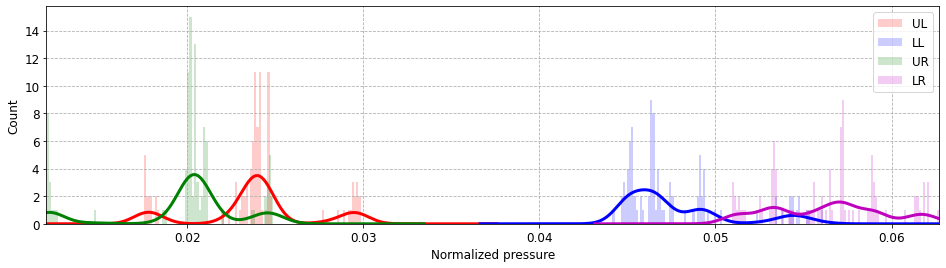

In [42]:
ut.plot_distributions(means_dict, 
                      title='NORMAL Movement: Mean pressure across-frames', 
                      xlabel='Normalized pressure',
                      kde=True)
plt.savefig('figs/xsensor_leo_normal_prs_hist.png', bbox_inches='tight')

In [43]:
#ut.plot_kdes(means_dict)
#plt.savefig('figs/xsensor_leo_normal_prs_kde.png', bbox_inches='tight')

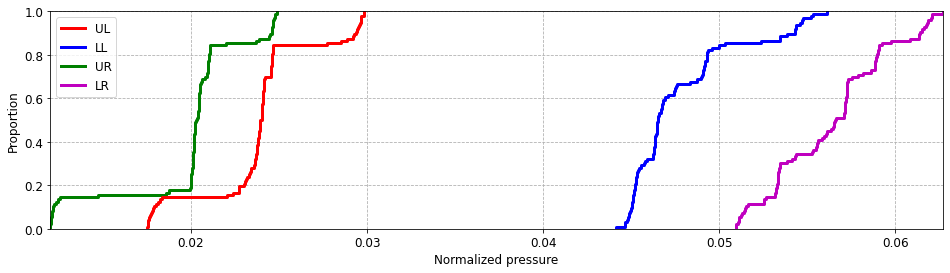

In [44]:
#del press_dict['$\mu$']
ut.plot_ecdf(means_dict, xlabel='Normalized pressure')
plt.savefig('figs/xsensor_leo_normal_prs_ecdf.png', bbox_inches='tight')

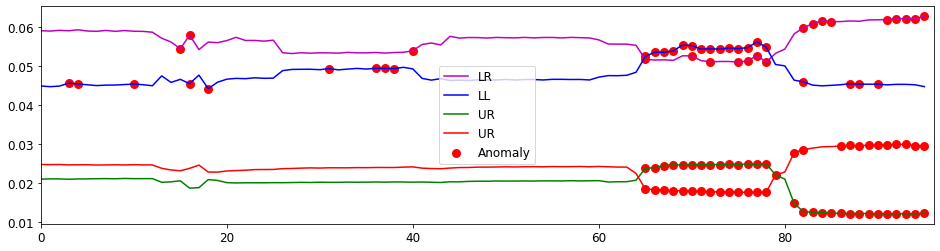

In [47]:
ut.anomaly_detection(means_dict, contamination=0.2)

## Stroke Patient 11ND

**NIHSS**: 8, **XSensor threshold**: 0

**Frames**: 16800 to 17058: 258 frames

**Weakness**: left side

16800-straight position

16889-16907 move

16916-16920 returns to the straight position

16960-16979 movement curved position

17058- returns to straight position

In [48]:
base_fn = 'data/StrokeUnit/P11ND_t0_f16800-17058_PS0008R4S0043_20210224_211657_PSMLAB'

In [49]:
# for test ONLY
#base_fn = 'StrokeUnit/P11ND_t0_f16468-20318_PS0008R4S0043_20210224_211657_PSMLAB_TEST'

# only if need to convert> csv --> pkl
if not os.path.exists(base_fn + '_pkl.pkl'):
    ut.clean_csv(base_fn + '.csv', base_fn + '_csv_clean.csv')
    pres_dat = ut.read_csv_data(base_fn + '_csv_clean.csv')
    ut.data_to_pkl(pres_dat, base_fn + '_pkl.pkl')

press_data = ut.load_pkl(base_fn + '_pkl.pkl')
print('--> shape:', press_data.shape)
# removing 2 frames outliers
press_data = press_data[0:257,:,:]

--> Data loaded!
--> shape: (260, 118, 48)


In [50]:
# can remove the first 60 frames and the last 16
press_data = press_data[60:-16,:,:]
press_data.shape

(181, 118, 48)

In [51]:
# for later calculate the shaded areas
f_shift = lambda f : f - 16860

print('--> sanity check. Frame 16860:', f_shift(16860))

--> sanity check. Frame 16860: 0


In [52]:
pts_dict = {}

pts_dict['vert'] = ut.frames_medaxis(press_data, dataset='XSensor', t=20, axis=0)
pts_dict['horiz'] = ut.frames_medaxis(press_data, dataset='XSensor', t=20, axis=1)

100%|███████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 200.67it/s]


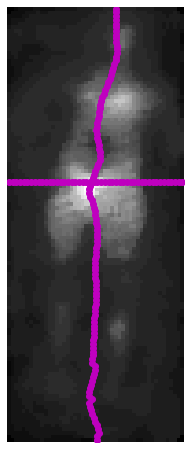

In [53]:
#frame_number = 125

#img_frame, img_bin = ut.get_frame(press_data, frame_number, dataset='XSensor', mask=True, t=20)
#ut.plot_img_marks(img_frame, img_bin, frames_pts[frame_number])

frame_number = 65

img_frame, img_bin = ut.get_frame(press_data, frame_number, dataset='XSensor', mask=True)

pts_vert = pts_dict['vert'][frame_number]
pts_horiz = pts_dict['horiz'][frame_number]

ut.plot_img_marks(img_frame, dots_v=pts_vert, dots_h=pts_horiz)

In [54]:
#right_means, left_means = ut.left_right_analysis(press_data, frames_pts, dataset='XSensor')

#prs_mean = np.mean([left_means, right_means], axis=0)

#right_means = ut.rolling_window(right_means, 8)
#left_means = ut.rolling_window(left_means, 8)
#prs_mean = ut.rolling_window(prs_mean, 8)

means_dict = ut.quadrant_analysis(press_data, pts_dict, dataset='XSensor', func=np.mean)

Quadrant analysis...


100%|███████████████████████████████████████████████████████████████████████████████| 181/181 [00:00<00:00, 532.35it/s]


In [55]:
f_shift(16889)

29

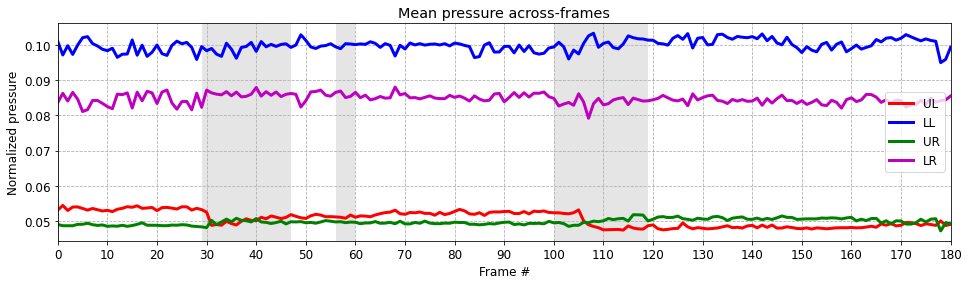

In [56]:
#press_dict = {
#    'L': left_means,
#    'R': right_means,
#    '$\mu$': prs_mean}

shaded_areas = {
    'moves to crossed pos1': [f_shift(16889), f_shift(16907)],
    'returns to straight pos': [f_shift(16916), f_shift(16920)],
    'moves to crossed pos2': [f_shift(16960), f_shift(16979)]}

ut.plot_pressures(means_dict, shaded_areas=shaded_areas, 
                  title='Mean pressure across-frames', 
                  ylabel='Normalized pressure');
plt.savefig('figs/xsensor_p11nd_prs_frame.png', bbox_inches='tight')

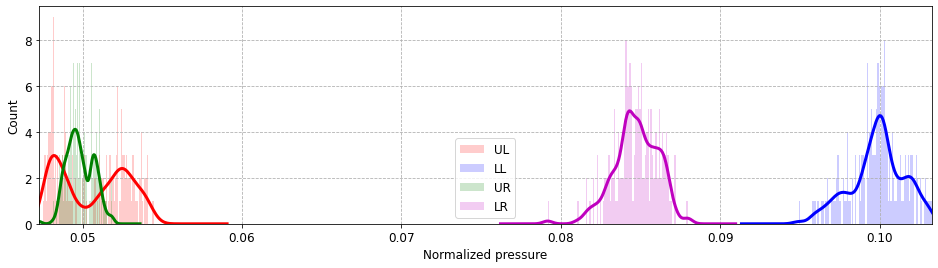

In [57]:
ut.plot_distributions(means_dict, xlabel='Normalized pressure', kde=True)
plt.savefig('figs/xsensor_p11nd_prs_hist.png', bbox_inches='tight')

In [58]:
#ut.plot_kdes(means_dict)
#plt.savefig('xsensor_p11nd_prs_kde.png', bbox_inches='tight')

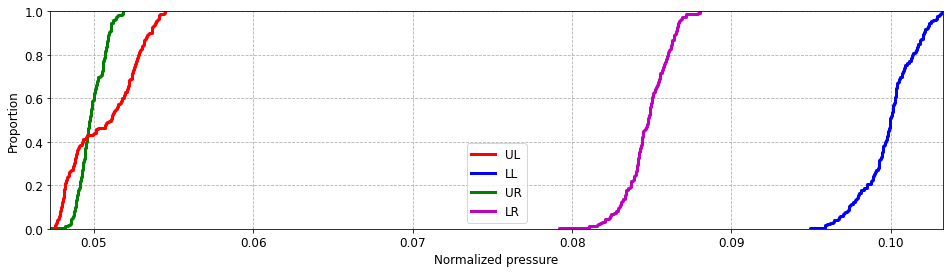

In [59]:
#del press_dict['$\mu$']
ut.plot_ecdf(means_dict, xlabel='Normalized pressure')
plt.savefig('figs/xsensor_p11nd_prs_ecdf.png', bbox_inches='tight')

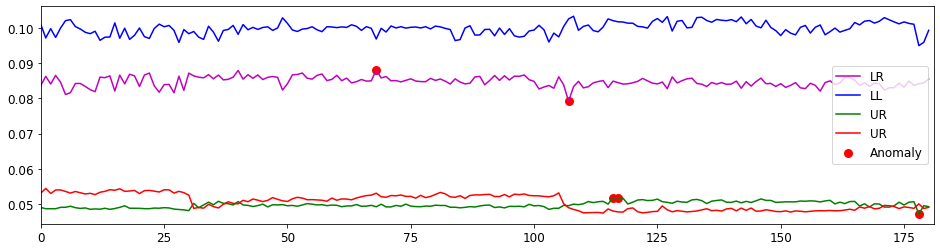

In [63]:
ut.anomaly_detection(means_dict, contamination=1e-2)

## Stroke Patient 18DD

**NIHSS**: 12, **XSensor threshold**: 0

**Frames**: 58636 to 59978

**Weakness**: left side

In [64]:
base_fn = 'data/StrokeUnit/P18DD_t0_f58636-59978_PS0008R1S0023_20020101_133326_PSMLAB_csv'

# for later calculate the shaded areas
f_shift = lambda f : f - 58636

In [65]:
# for test ONLY
#base_fn = 'StrokeUnit/P11ND_t0_f16468-20318_PS0008R4S0043_20210224_211657_PSMLAB_TEST'

# only if need to convert> csv --> pkl
if not os.path.exists(base_fn + '_pkl.pkl'):
    ut.clean_csv(base_fn + '.csv', base_fn + '_csv_clean.csv')
    pres_dat = ut.read_csv_data(base_fn + '_csv_clean.csv')
    ut.data_to_pkl(pres_dat, base_fn + '_pkl.pkl')

press_data = ut.load_pkl(base_fn + '_pkl.pkl')

--> Data loaded!


In [66]:
press_data.shape

(1344, 118, 48)

In [67]:
pts_dict = {}

pts_dict['vert'] = ut.frames_medaxis(press_data, dataset='XSensor', t=20, axis=0)
pts_dict['horiz'] = ut.frames_medaxis(press_data, dataset='XSensor', t=20, axis=1)

100%|█████████████████████████████████████████████████████████████████████████████| 1344/1344 [00:05<00:00, 239.74it/s]


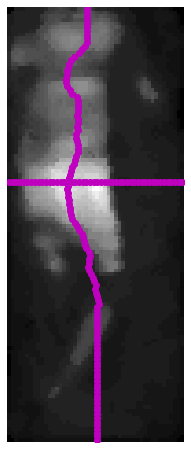

In [68]:
frame_number = 200

img_frame, img_bin = ut.get_frame(press_data, frame_number, dataset='XSensor', mask=True)

pts_vert = pts_dict['vert'][frame_number]
pts_horiz = pts_dict['horiz'][frame_number]

ut.plot_img_marks(img_frame, dots_v=pts_vert, dots_h=pts_horiz)

In [69]:
#right_means, left_means = ut.left_right_analysis(press_data, frames_pts, dataset='XSensor')

#prs_mean = np.mean([left_means, right_means], axis=0)

#right_means = ut.rolling_window(right_means, 8)
#left_means = ut.rolling_window(left_means, 8)
#prs_mean = ut.rolling_window(prs_mean, 8)

means_dict = ut.quadrant_analysis(press_data, pts_dict, dataset='XSensor')

Quadrant analysis...


100%|█████████████████████████████████████████████████████████████████████████████| 1344/1344 [00:01<00:00, 818.72it/s]


In [70]:
f_shift(16889)

-41747

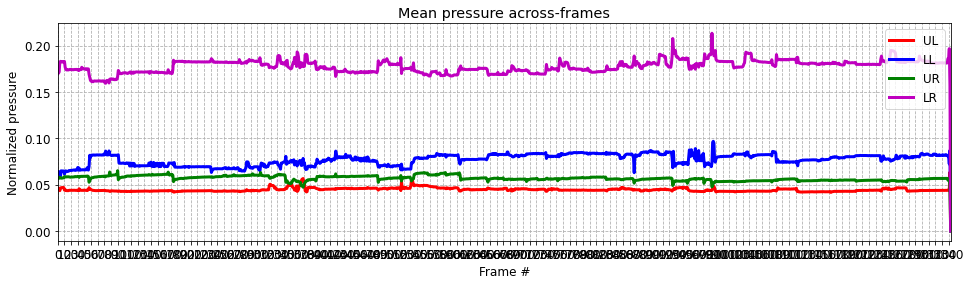

In [71]:
shaded_areas = {
    'moves to crossed pos1': [f_shift(16889), f_shift(16907)],
    'returns to straight pos': [f_shift(16916), f_shift(16920)],
    'moves to crossed pos2': [f_shift(16960), f_shift(16979)]}

ut.plot_pressures(means_dict, shaded_areas=None,title='Mean pressure across-frames', ylabel='Normalized pressure');
plt.savefig('figs/xsensor_p18dd_prs_frame.png', bbox_inches='tight')

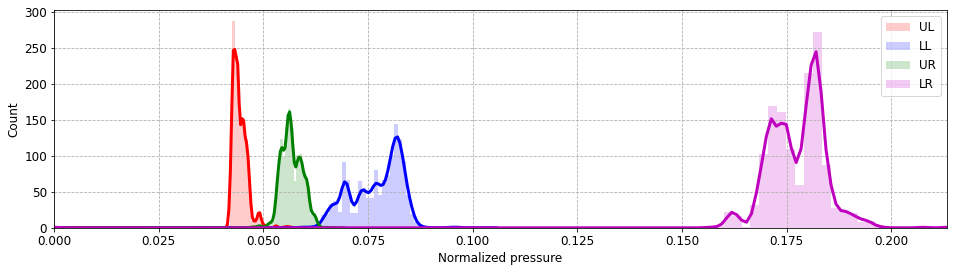

In [72]:
ut.plot_distributions(means_dict, xlabel='Normalized pressure',kde=True)
plt.savefig('figs/xsensor_p18dd_prs_hist.png', bbox_inches='tight')

In [73]:
#ut.plot_kdes(means_dict)
#plt.savefig('xsensor_p18dd_prs_kde.png', bbox_inches='tight')

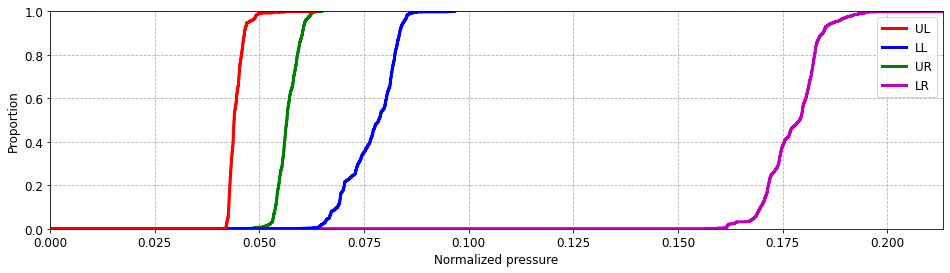

In [74]:
#del press_dict['$\mu$']
ut.plot_ecdf(means_dict, xlabel='Normalized pressure')
plt.savefig('figs/xsensor_p18dd_prs_ecdf.png', bbox_inches='tight')

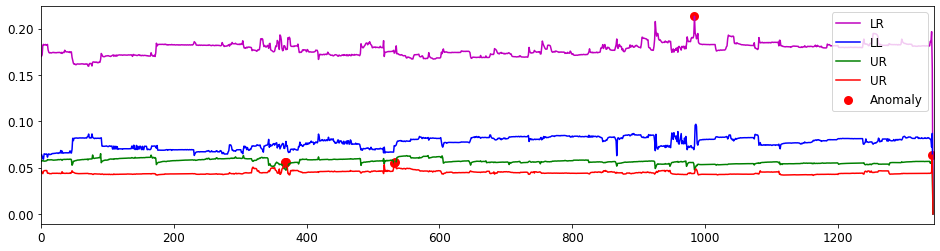

In [78]:
ut.anomaly_detection(means_dict, contamination=1e-10)

## Stroke Patient 31

**NIHSS**: 13, **XSensor threshold**: 0

**Weakness**: right side

In [18]:
base_fn = 'data/StrokeUnit/P31AM_PS0008R4S0030_20210604_212622_PSMLAB_t0_f44477-44535'

# for later calculate the shaded areas
f_shift = lambda f : abs(f - 44477) # This comes from manual annotation

In [4]:
# only if need to convert> csv --> pkl
if not os.path.exists(base_fn + '_pkl.pkl'):
    ut.clean_csv(base_fn + '.csv', base_fn + '_csv_clean.csv')
    pres_dat = ut.read_csv_data(base_fn + '_csv_clean.csv')
    ut.data_to_pkl(pres_dat, base_fn + '_pkl.pkl')

press_data = ut.load_pkl(base_fn + '_pkl.pkl')

--> Data loaded!


In [5]:
press_data = press_data[:-1, :, :]
press_data.shape

(59, 118, 48)

100%|█████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 235.97it/s]


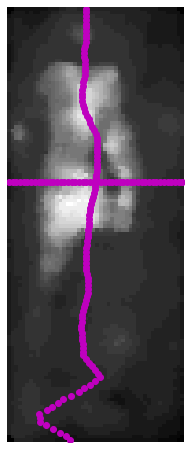

In [6]:
pts_dict = {}
pts_dict['vert'] = ut.frames_medaxis(press_data, dataset='XSensor', t=20, axis=0)
pts_dict['horiz'] = ut.frames_medaxis(press_data, dataset='XSensor', t=20, axis=1)

frame_number = 20

img_frame, img_bin = ut.get_frame(press_data, frame_number, dataset='XSensor', mask=True)

pts_vert = pts_dict['vert'][frame_number]
pts_horiz = pts_dict['horiz'][frame_number]

ut.plot_img_marks(img_frame, dots_v=pts_vert, dots_h=pts_horiz)

In [7]:
means_dict = ut.quadrant_analysis(press_data, pts_dict, dataset='XSensor')

Quadrant analysis...


100%|█████████████████████████████████████████████████████████████████████████████████| 59/59 [00:00<00:00, 608.23it/s]


30 38


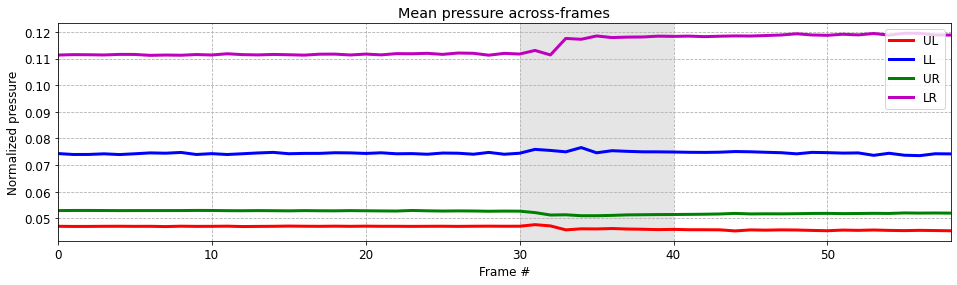

In [20]:

shaded_areas = {
    'one leg moves': [f_shift(44507), f_shift(44517)]
    }

print(f_shift(44507), f_shift(44515))

ut.plot_pressures(means_dict, shaded_areas=shaded_areas, title='Mean pressure across-frames', ylabel='Normalized pressure');

In [9]:
relative_mov = ut.relative_movement(press_data, means_dict, dataset='XSensor')

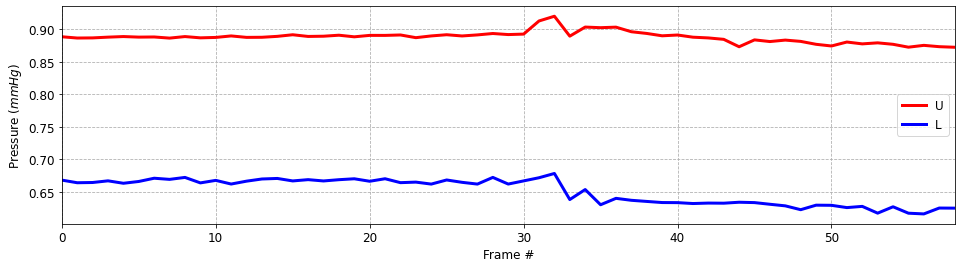

In [10]:
ut.plot_pressures(relative_mov)

In [22]:
means_dict.keys()

dict_keys(['UL', 'LL', 'UR', 'LR'])

In [172]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

model = IsolationForest(contamination=1e-10) # 0-0.5 or 'auto'
scl = StandardScaler()

In [173]:
df = pd.DataFrame.from_dict(means_dict)

In [178]:
scl_lr = scl.fit_transform(np.reshape(df['LR'].values, (-1,1)))
pred = model.fit_predict(scl_lr) # outlier is -1, inlier is 1
aLR = df.loc[pred == -1, ['LR']]

scl_ll = scl.fit_transform(np.reshape(df['LL'].values, (-1,1)))
pred = model.predict(scl_ll)
aLL = df.loc[pred == -1, ['LL']]

scl_ur = scl.fit_transform(np.reshape(df['UR'].values, (-1,1)))
pred = model.predict(scl_ur)
aUR = df.loc[pred == -1, ['UR']]

scl_ul = scl.fit_transform(np.reshape(df['UL'].values, (-1,1)))
pred = model.predict(scl_ul)
aUL = df.loc[pred == -1, ['UL']]

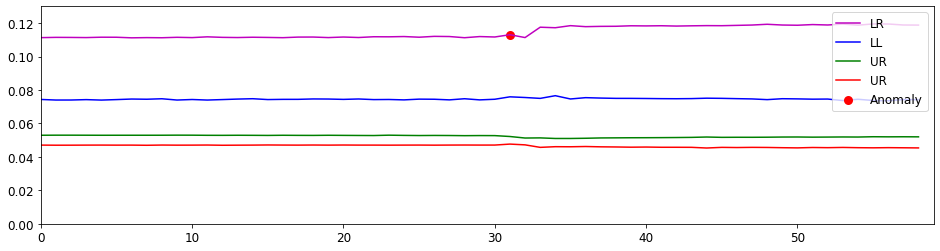

In [183]:
fig, ax = plt.subplots(figsize=(16,4))

ax.plot(df.index, df['LR'], color='m', label = 'LR')
ax.plot(df.index, df['LL'], color='blue', label = 'LL')
ax.plot(df.index, df['UR'], color='green', label = 'UR')
ax.plot(df.index, df['UL'], color='red', label = 'UR')

ax.scatter(aLR.index, aLR['LR'], color='red', linewidths=3, label = 'Anomaly')
ax.scatter(aLL.index, aLL['LL'], color='red')
ax.scatter(aUR.index, aUR['UR'], color='red')
ax.scatter(aUL.index, aUL['UL'], color='red')

plt.xlim([0, len(df['LR'])])
plt.ylim([0,0.13])
plt.legend()
plt.show();

In [ ]:
plt.savefig('figs/xsensor_p31am_prs_frame.png', bbox_inches='tight')